## Recognising Blood Cell Types from Sample Images
The blood cell images dataset contains roughly 12,000 augmented images of blood cells. There are approximately 3,000 images for each of 4 different cell types. The cell types are Eosinophil, Lymphocyte, Monocyte, and Neutrophil. 

I shall be attempting to build a visualition model that can recognise and classify the cell types based on these images.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [3]:
import os
import cv2
from datetime import datetime

label_to_type = {0: "NEUTROPHIL", 1: "EOSINOPHIL", 2: "MONOCYTE", 3: "LYMPHOCYTE"}
type_to_label = {"NEUTROPHIL": 0, "EOSINOPHIL": 1, "MONOCYTE": 2, "LYMPHOCYTE": 3}

train_dir = "/dataset2-master/dataset2-master/images/TRAIN/"
    
x_train = []
y_train = []

for cell_type in os.listdir(train_dir):
    print("{0}: Loading {1} training images...".format(datetime.now().time(), cell_type))
    for img in os.listdir(train_dir + cell_type):
        y_train.append(type_to_label[cell_type])
        img = plt.imread(train_dir + cell_type + "/" + img)
        img = cv2.resize(img, (60, 90))
        x_train.append(img)
        
x_train = np.array(x_train)
y_train = np.array(y_train)

18:12:12.460047: Loading MONOCYTE training images...
18:12:24.372653: Loading EOSINOPHIL training images...
18:12:36.423913: Loading NEUTROPHIL training images...
18:12:48.173046: Loading LYMPHOCYTE training images...


In [19]:
x_train.shape

(9957, 90, 60, 3)

So there are 9957 images within the training set. The images have been resized to 60x90 to make them smaller and less demanding on memory resources. The images are RGB, hence the 3 channels.

In [4]:
test_dir = "dataset2-master/dataset2-master/images/TEST/"

x_test = []
y_test = []

for cell_type in os.listdir(test_dir):
    print("{0}: Loading {1} test images...".format(datetime.now().time(), cell_type))
    for img in os.listdir(test_dir + cell_type):
        y_test.append(type_to_label[cell_type])
        img = plt.imread(test_dir + cell_type + "/" + img)
        img = cv2.resize(img, (60, 90))
        x_test.append(img)

x_test = np.array(x_test)
y_test = np.array(y_test)

18:13:00.587963: Loading MONOCYTE test images...
18:13:03.429348: Loading EOSINOPHIL test images...
18:13:06.240398: Loading NEUTROPHIL test images...
18:13:09.720009: Loading LYMPHOCYTE test images...


In [20]:
x_test.shape

(2487, 90, 60, 3)

There are 2487 images within the test set. We have now loaded all the images for both sets into memory, ready for learning. 

# Dataset Visualisation
Just so we know what we're working with, he's an example image of each cell type. With the human eye we can clearly distinguish the differences between them. Hopefully I can train a CNN that can accurately classify the images as efficiently as a human can.

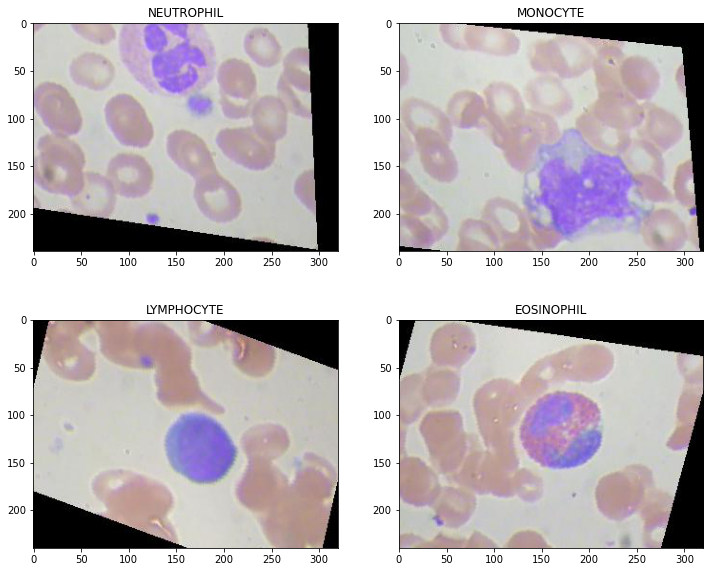

In [5]:
train_dir = "dataset2-master/dataset2-master/images/TRAIN/"
sample_images = ["NEUTROPHIL/_0_1095.jpeg", "MONOCYTE/_0_1173.jpeg", "LYMPHOCYTE/_0_1063.jpeg", "EOSINOPHIL/_0_1169.jpeg"]
labels = ["NEUTROPHIL", "MONOCYTE", "LYMPHOCYTE", "EOSINOPHIL"]

fig, ax = plt.subplots(2,2, figsize=(12,10))

n = 0
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(plt.imread(train_dir + sample_images[n]))
        ax[i,j].set_title(labels[n])
        n += 1

In [6]:
x_train = x_train / 255
x_test = x_test / 255

Normalising the dataset so each pixel value is between 0 and 1, rather than 0 and 255.

In [7]:
train_gen = ImageDataGenerator(
        rotation_range=30,
        zoom_range=0.1,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
        )

train_gen.fit(x_train)

This image data generator will be used for data augmentation, so that the batches of images will have random changes made to them like rotation and zoom. This provides more data than the original dataset and hopefully provides an even better validation accuracy. 

# Visualisation Model

In [14]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(90,60,3)))
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=4, activation='softmax'))

adam = keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 90, 60, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 45, 30, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 45, 30, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 45, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 23, 15, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 23, 15, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 23, 15, 16)       

I'm going to be using a high batch size of 256, with a very low learning rate of 0.00005 for the Adam optimiser. I've tried experimenting with various hyperparameter values and it seems that a lower batch size is too noisy, and causes the validation accuracy to greatly fluctuate. 

Instead I want the training to be slow and steady, so I've set the learning rate much lower than normal, with hundreds of epochs so that the model can gradually converge and hopefully make the validation accuracy less unstable.

In [15]:
history = model.fit(train_gen.flow(x_train, y_train, batch_size=256), epochs=300, validation_data=(x_test, y_test))

Train for 39 steps, validate on 2487 samples
Epoch 1/300
39/39 [==============================] - 16s 399ms/step - loss: 4.3080 - accuracy: 0.2412 - val_loss: 3.3212 - val_accuracy: 0.2509
Epoch 2/300
39/39 [==============================] - 14s 351ms/step - loss: 4.1428 - accuracy: 0.2517 - val_loss: 3.3875 - val_accuracy: 0.2493
Epoch 3/300
39/39 [==============================] - 14s 358ms/step - loss: 4.0227 - accuracy: 0.2593 - val_loss: 3.4462 - val_accuracy: 0.2493
Epoch 4/300
39/39 [==============================] - 14s 347ms/step - loss: 3.9961 - accuracy: 0.2615 - val_loss: 3.5417 - val_accuracy: 0.2493
Epoch 5/300
39/39 [==============================] - 14s 371ms/step - loss: 3.9225 - accuracy: 0.2692 - val_loss: 3.6343 - val_accuracy: 0.2493
Epoch 6/300
39/39 [==============================] - 14s 358ms/step - loss: 3.8717 - accuracy: 0.2807 - val_loss: 3.7112 - val_accuracy: 0.2493
Epoch 7/300
39/39 [==============================] - 14s 358ms/step - loss: 3.8243 - accura

39/39 [==============================] - 16s 399ms/step - loss: 1.9300 - accuracy: 0.6403 - val_loss: 2.0695 - val_accuracy: 0.6192
Epoch 58/300
39/39 [==============================] - 16s 408ms/step - loss: 1.8986 - accuracy: 0.6532 - val_loss: 1.8439 - val_accuracy: 0.6759
Epoch 59/300
39/39 [==============================] - 16s 403ms/step - loss: 1.8652 - accuracy: 0.6582 - val_loss: 2.2905 - val_accuracy: 0.5637
Epoch 60/300
39/39 [==============================] - 15s 380ms/step - loss: 1.8331 - accuracy: 0.6576 - val_loss: 1.9943 - val_accuracy: 0.6289
Epoch 61/300
39/39 [==============================] - 15s 379ms/step - loss: 1.8199 - accuracy: 0.6659 - val_loss: 2.3628 - val_accuracy: 0.5682
Epoch 62/300
39/39 [==============================] - 15s 391ms/step - loss: 1.7982 - accuracy: 0.6663 - val_loss: 1.7688 - val_accuracy: 0.6852
Epoch 63/300
39/39 [==============================] - 15s 389ms/step - loss: 1.7697 - accuracy: 0.6757 - val_loss: 1.7670 - val_accuracy: 0.686

39/39 [==============================] - 15s 386ms/step - loss: 0.8887 - accuracy: 0.8444 - val_loss: 1.0058 - val_accuracy: 0.8086
Epoch 114/300
39/39 [==============================] - 14s 369ms/step - loss: 0.8864 - accuracy: 0.8445 - val_loss: 1.1516 - val_accuracy: 0.7551
Epoch 115/300
39/39 [==============================] - 15s 390ms/step - loss: 0.8637 - accuracy: 0.8489 - val_loss: 1.0277 - val_accuracy: 0.7986
Epoch 116/300
39/39 [==============================] - 15s 376ms/step - loss: 0.8594 - accuracy: 0.8472 - val_loss: 1.1218 - val_accuracy: 0.7620
Epoch 117/300
39/39 [==============================] - 15s 377ms/step - loss: 0.8580 - accuracy: 0.8441 - val_loss: 1.0576 - val_accuracy: 0.7841
Epoch 118/300
39/39 [==============================] - 15s 377ms/step - loss: 0.8397 - accuracy: 0.8533 - val_loss: 1.3258 - val_accuracy: 0.6972
Epoch 119/300
39/39 [==============================] - 15s 374ms/step - loss: 0.8312 - accuracy: 0.8537 - val_loss: 1.6169 - val_accuracy:

39/39 [==============================] - 15s 372ms/step - loss: 0.4439 - accuracy: 0.9035 - val_loss: 0.7910 - val_accuracy: 0.8126
Epoch 170/300
39/39 [==============================] - 15s 375ms/step - loss: 0.4418 - accuracy: 0.9043 - val_loss: 0.7072 - val_accuracy: 0.8207
Epoch 171/300
39/39 [==============================] - 16s 407ms/step - loss: 0.4319 - accuracy: 0.9049 - val_loss: 0.8762 - val_accuracy: 0.8054
Epoch 172/300
39/39 [==============================] - 14s 368ms/step - loss: 0.4248 - accuracy: 0.9088 - val_loss: 0.7287 - val_accuracy: 0.8255
Epoch 173/300
39/39 [==============================] - 14s 360ms/step - loss: 0.4269 - accuracy: 0.9046 - val_loss: 0.7929 - val_accuracy: 0.8006
Epoch 174/300
39/39 [==============================] - 15s 390ms/step - loss: 0.4232 - accuracy: 0.9080 - val_loss: 0.7464 - val_accuracy: 0.8094
Epoch 175/300
39/39 [==============================] - 15s 386ms/step - loss: 0.4142 - accuracy: 0.9077 - val_loss: 1.0523 - val_accuracy:

39/39 [==============================] - 14s 354ms/step - loss: 0.2655 - accuracy: 0.9336 - val_loss: 0.8354 - val_accuracy: 0.7760
Epoch 226/300
39/39 [==============================] - 15s 380ms/step - loss: 0.2650 - accuracy: 0.9280 - val_loss: 0.9556 - val_accuracy: 0.7491
Epoch 227/300
39/39 [==============================] - 14s 347ms/step - loss: 0.2640 - accuracy: 0.9299 - val_loss: 0.6645 - val_accuracy: 0.8175
Epoch 228/300
39/39 [==============================] - 14s 357ms/step - loss: 0.2579 - accuracy: 0.9315 - val_loss: 0.8981 - val_accuracy: 0.7797
Epoch 229/300
39/39 [==============================] - 14s 352ms/step - loss: 0.2622 - accuracy: 0.9286 - val_loss: 0.7144 - val_accuracy: 0.8154
Epoch 230/300
39/39 [==============================] - 15s 378ms/step - loss: 0.2588 - accuracy: 0.9323 - val_loss: 0.7569 - val_accuracy: 0.8066
Epoch 231/300
39/39 [==============================] - 14s 348ms/step - loss: 0.2576 - accuracy: 0.9285 - val_loss: 0.8953 - val_accuracy:

39/39 [==============================] - 13s 345ms/step - loss: 0.1894 - accuracy: 0.9453 - val_loss: 0.8089 - val_accuracy: 0.8002
Epoch 282/300
39/39 [==============================] - 14s 362ms/step - loss: 0.1801 - accuracy: 0.9488 - val_loss: 0.6875 - val_accuracy: 0.8315
Epoch 283/300
39/39 [==============================] - 14s 350ms/step - loss: 0.1884 - accuracy: 0.9454 - val_loss: 0.8335 - val_accuracy: 0.8058
Epoch 284/300
39/39 [==============================] - 14s 349ms/step - loss: 0.1826 - accuracy: 0.9469 - val_loss: 1.1866 - val_accuracy: 0.7181
Epoch 285/300
39/39 [==============================] - 14s 358ms/step - loss: 0.1902 - accuracy: 0.9425 - val_loss: 1.3209 - val_accuracy: 0.7045
Epoch 286/300
39/39 [==============================] - 14s 362ms/step - loss: 0.1877 - accuracy: 0.9457 - val_loss: 0.8430 - val_accuracy: 0.7949
Epoch 287/300
39/39 [==============================] - 14s 362ms/step - loss: 0.1832 - accuracy: 0.9465 - val_loss: 0.8622 - val_accuracy:

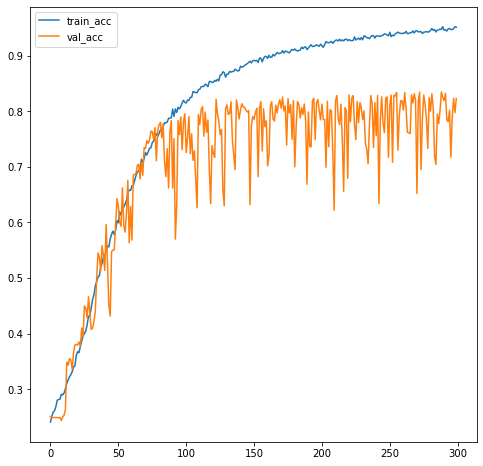

In [16]:
plt.figure(figsize=(8, 8))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()

The validation accuracy is still quite unstable, but a lot better than I've previously seen it. Also the validation accuracy seems to plateu at around 80%, whilst the training accuracy continues to gradually improve. This is a clear sign of overfitting.

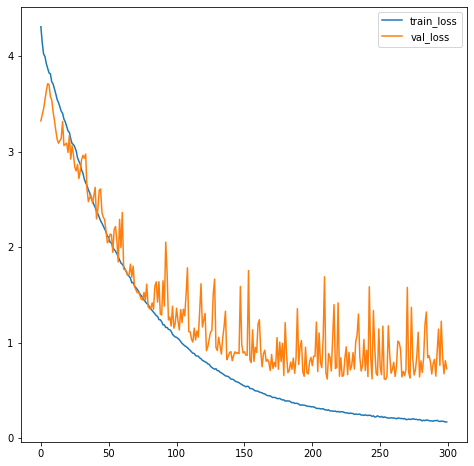

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

[Text(51.0, 0.5, 'True Labels'), Text(0.5, 51.0, 'Predictions')]

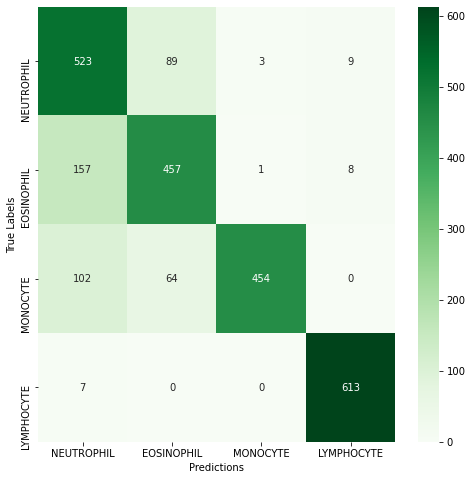

In [18]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict_classes(x_test)
cm = confusion_matrix(y_test, y_pred, labels=[i for i in range(4)])
cm = pd.DataFrame(cm , index=[label_to_type[i] for i in range(4)] , columns=[label_to_type[i] for i in range(4)])
plt.figure(figsize=(8,8))
ax = sns.heatmap(cm, cmap= "Greens", annot=True, fmt='')
ax.set(xlabel='Predictions', ylabel='True Labels')

In [21]:
model.save_weights("/kaggle/working/model_weights.h5")

The final validation accuracy of this model is 0.8231 (82.31%), and the final training accuracy is 0.9511 (95.11%). The model is still overfitting, and the validation accuracy/loss is still quite unstable as can be seen from the graph plots above. 

Using the confusion matrix above, we can see that the model has fit very well to Lymphocyte cells, but less well to the other 3 cell types. The accuracy for each cell type is as follows:

* Neutrophil - 523/624 - 83.81%
* Eosinophil - 457/623 - 73.35%
* Monocyte - 454/620 - 73.23%
* Lymphocyte - 613/620 - 98.87%

# Conclusion
The model's final accuracy of 82.31% on the test set is not as high as I hoped for, and certainly could not be used reliably for classifying blood cells on it's own without a human second-opinion. However the model could be used to determine whether a cell is of type Lymphocyte, as it correctly predicts that type of cell 98.87% of the time. 

With regards to the model overfitting, the model's architecture is probably the next thing to look at. Perhaps some dropout layers between the convolutional layers, or less layers in general. Regularisation and dropout is already being used on the dense layers, as is batch normalisation throughout all layers in the model. An even smaller learning rate for Adam could also be tried out, or a higher batch size.